# Task 1: Preprocessing the Data
Clearing and merging two datasets

In [ ]:
import pandas as pd 
import numpy as np
import sklearn as sk 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix


from sklearn import mixture

sns.set()




In [ ]:
#importing the aggregated daily hospitalization data and loading it into a pandas dataframe
url_aggdata = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv'
df_agg = pd.read_csv(url_aggdata)
df_agg.head()




/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,open_covid_region_code,region_name,date,cases_cumulative,cases_new,cases_cumulative_per_million,cases_new_per_million,deaths_cumulative,deaths_new,deaths_cumulative_per_million,deaths_new_per_million,tests_new,tests_cumulative,tests_cumulative_per_thousand,tests_new_per_thousand,test_units,hospitalized_current,hospitalized_cumulative,hospitalized_new,discharged_new,discharged_cumulative,icu_current,icu_cumulative,ventilator_current,school_closing,school_closing_flag,workplace_closing,workplace_closing_flag,cancel_public_events_flag,restrictions_on_gatherings,restrictions_on_gatherings_flag,close_public_transit,close_public_transit_flag,stay_at_home_requirements,stay_at_home_requirements_flag,restrictions_on_internal_movement,restrictions_on_internal_movement_flag,international_travel_controls,income_support,income_support_flag,debt_contract_relief,fiscal_measures,international_support,public_information_campaigns,public_information_campaigns_flag,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,wildcard,confirmed_cases,confirmed_deaths,stringency_index,stringency_index_for_display,stringency_legacy_index,stringency_legacy_index_for_display,government_response_index,government_response_index_for_display,containment_health_index,containment_health_index_for_display,economic_support_index,economic_support_index_for_display
0,AFG,Afghanistan,2019-12-31,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,2020-01-01,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AFG,Afghanistan,2020-01-02,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AFG,Afghanistan,2020-01-03,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AFG,Afghanistan,2020-01-04,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#importing the weekly US symptoms data and loading it into a pandas dataframe
url_searchdata ='https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv'
df_search = pd.read_csv(url_searchdata)
print(df_search.shape)
df_search.head()


(640, 430)


,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Throat irritation,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,12.69,NaN,NaN,NaN,NaN,NaN,12.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.31,NaN,NaN,NaN,...,NaN,NaN,15.86,NaN,NaN,NaN,NaN,NaN,11.90,NaN,NaN,NaN,NaN,18.84,13.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.08,9.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.28,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,9.56,NaN,NaN,NaN,NaN,NaN,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.20,NaN,NaN,NaN,...,NaN,NaN,12.24,NaN,NaN,NaN,NaN,NaN,7.84,NaN,NaN,NaN,NaN,16.83,13.01,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,15.30,8.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.26,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.90,NaN,NaN,NaN,...,NaN,NaN,17.66,NaN,NaN,NaN,NaN,NaN,15.27,NaN,NaN,NaN,NaN,18.40,12.14,NaN,NaN,7.54,NaN,NaN,NaN,NaN,NaN,10.30,16.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.48,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,NaN,NaN,NaN,15.31,7.47,NaN,NaN,NaN,NaN,15.67,NaN,NaN,NaN,NaN,NaN,NaN,7.47,NaN,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,12.03,NaN,NaN,NaN,...,NaN,NaN,12.76,NaN,NaN,NaN,NaN,NaN,9.84,NaN,NaN,NaN,NaN,20.41,17.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.93,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,NaN,NaN,NaN,8.81,NaN,NaN,NaN,NaN,NaN,13.87,NaN,NaN,NaN,NaN,NaN,NaN,8.06,NaN,NaN,NaN,12.56,NaN,NaN,NaN,NaN,NaN,14.24,NaN,NaN,NaN,...,NaN,NaN,16.68,NaN,NaN,NaN,NaN,NaN,10.68,NaN,NaN,NaN,NaN,20.62,16.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.24,10.68,NaN,NaN,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.93,NaN,NaN


In [ ]:
# filter out the other region codes, only taking regions that starts with "US-"
df_agg = df_agg[df_agg['open_covid_region_code'].str.startswith(
    "US-")]

# adjusting the time interval to match the weekly_symptoms dataset
df_agg['date'] = pd.to_datetime(df_agg['date'])
df_agg = df_agg[df_agg['date'] >= '2020-01-06']

# removing columns that only contains NaN values
df_agg.dropna(axis="columns", how="all", inplace=True)

# setting up a week column and getting the week no of the year
df_agg['week'] = df_agg['date'].dt.isocalendar().week
df_agg.fillna(0, inplace=True)

# filter  the hospitalization data and converting dailiy data into weekly with groupby() and agg()
logic = {
    'date':'first',

    'hospitalized_new': 'sum',
   
    
}

df_agg2 = df_agg.groupby(
    ['open_covid_region_code', 'week'], as_index=False).agg(logic)

df_search.sort_values(['open_covid_region_code', 'date'], ascending=[
                         True, True], inplace=True)


print(df_agg2.shape)
df_agg2.head()

(1857, 4)


,open_covid_region_code,week,date,hospitalized_new
0,US-AK,10,2020-03-06,0.0
1,US-AK,11,2020-03-09,0.0
2,US-AK,12,2020-03-16,0.0
3,US-AK,13,2020-03-23,6.0
4,US-AK,14,2020-03-30,14.0


In [ ]:
# cleaning all NaN and mostly NaN columns (too many invalid entries)
df_search.dropna(axis="columns", how="all", inplace=True)
df_search.dropna(axis="columns", thresh=200, inplace=True)
df_search['date'] = pd.to_datetime(df_search['date'])
df_search['week'] = df_search['date'].dt.isocalendar().week
print(df_search.shape)
df_search.drop(columns = ['country_region_code', 'country_region','sub_region_1', 'sub_region_1_code'], inplace=True)
df_search.fillna(df_search.iloc[:,2:].mean(axis =0), inplace=True)



# sort by the region and week of the year
df_search.sort_values(['open_covid_region_code', 'week'], ascending=[
                         True, True], inplace=True)
print(df_search.shape)
df_search.head(10)


(640, 89)
(640, 85)


,open_covid_region_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Burning Chest Pain,symptom:Cataplexy,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Crackles,symptom:Crepitus,symptom:Cyanosis,symptom:Depersonalization,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dysuria,symptom:Epiphora,symptom:Esophagitis,symptom:Eye pain,symptom:Facial swelling,symptom:Fibrocystic breast changes,symptom:Focal seizure,symptom:Gastroparesis,symptom:Gingival recession,symptom:Globus pharyngis,symptom:Hemolysis,symptom:Hemoptysis,symptom:Hepatic encephalopathy,symptom:Hepatotoxicity,...,symptom:Hyperventilation,symptom:Hypochondriasis,symptom:Hypomania,symptom:Laryngitis,symptom:Male infertility,symptom:Mitral insufficiency,symptom:Muscle atrophy,symptom:Myoclonus,symptom:Nasal polyp,symptom:Neck mass,symptom:Neutropenia,symptom:Night terror,symptom:Nocturnal enuresis,symptom:Nystagmus,symptom:Onychorrhexis,symptom:Papule,symptom:Pericarditis,symptom:Petechia,symptom:Photophobia,symptom:Polydipsia,symptom:Polyuria,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Rheum,symptom:Rumination,symptom:Sensitivity to sound,symptom:Shallow breathing,symptom:Spasticity,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Trichoptilosis,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,week
0,US-AK,2020-01-06,12.690000,10.076575,9.568169,12.29,12.689555,13.055904,16.930406,10.31,11.10,8.920000,11.100000,7.930000,9.44688,12.29,12.10,18.05,10.669837,8.330000,12.490000,10.51,12.100000,12.773484,7.930000,7.930000,15.47,8.130000,9.12,15.47,8.720000,17.650000,9.52,11.50,11.50000,7.930000,9.120000,15.070000,8.661496,14.67,...,10.11,10.91,12.890000,14.47,18.05,11.50,11.348255,10.510000,9.520000,11.90,12.225556,13.480000,12.29,12.89,9.72,11.30,8.13000,11.10,11.50,9.303899,9.120000,11.300000,11.30,11.311522,18.24,8.769031,13.680000,8.13,12.302506,9.120000,8.65113,10.31,9.91,7.93,14.28,11.90,10.475645,9.910000,19.437306,2
1,US-AK,2020-01-13,9.560000,10.076575,9.568169,12.62,12.689555,13.055904,16.930406,13.20,13.20,8.610000,10.900000,11.860000,9.44688,14.92,11.47,34.81,9.950000,8.220000,8.706667,11.86,7.650000,11.090000,11.031202,9.060299,13.01,12.810000,10.71,11.67,11.670000,10.710000,11.67,16.64,13.20000,8.030000,11.997365,8.353815,8.661496,10.52,...,13.01,10.52,14.540000,11.28,11.09,8.22,13.960000,8.410000,7.650000,11.47,12.225556,13.390000,13.20,7.84,13.96,13.20,11.47000,11.09,8.22,9.303899,9.750000,7.840000,8.03,8.410000,20.46,11.470000,11.014727,8.80,12.302506,9.560000,9.18000,15.49,13.77,10.71,13.39,7.84,7.650000,8.410000,19.437306,3
2,US-AK,2020-01-20,11.428152,10.076575,9.568169,14.17,12.689555,7.360000,16.930406,14.90,10.49,8.280000,11.780000,11.960000,9.44688,11.04,11.59,19.14,8.830000,8.280000,10.490000,7.73,9.107976,10.120000,11.040000,8.460000,15.82,9.750000,9.20,15.27,10.860000,14.540000,16.38,13.25,9.02000,10.300000,11.997365,11.960000,9.200000,10.49,...,15.46,9.38,16.380000,16.38,8.83,11.04,10.490000,7.730000,17.480000,11.96,10.670000,9.020000,10.30,13.25,13.62,13.98,8.28000,10.49,10.86,8.460000,8.100000,10.860000,8.65,7.910000,18.40,9.200000,13.980000,8.46,12.302506,9.570000,8.46000,14.90,9.20,12.33,12.88,15.27,7.540000,16.190000,19.437306,4
3,US-AK,2020-01-27,15.310000,7.470000,9.568169,15.67,7.470000,13.055904,7.650000,12.03,11.84,13.120000,11.758655,12.030000,9.44688,13.85,12.94,15.49,9.840000,10.390000,12.390000,9.84,8.200000,8.560000,8.930000,8.020000,11.30,9.660000,10.57,12.57,11.480000,8.974103,14.94,11.84,15.31000,8.380000,8.930000,14.580000,8.661496,10.20,...,11.12,11.84,11.480000,11.30,13.12,10.93,10.930000,11.434501,8.

In [ ]:
# merged two dataframes on the common columns 'open_covid_region_code' and 'week'
df_merged = pd.merge(left=df_search, right=df_agg2, on=['open_covid_region_code', 'week'])
df_merged.fillna(0, inplace  = True)
df_merged.drop(columns=['week', 'date_y'])

# printing out the shapes for checking
print("Merged shape: ", df_merged.shape)
df_merged.head()

Merged shape:  (513, 87)


,open_covid_region_code,date_x,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Burning Chest Pain,symptom:Cataplexy,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Crackles,symptom:Crepitus,symptom:Cyanosis,symptom:Depersonalization,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dysuria,symptom:Epiphora,symptom:Esophagitis,symptom:Eye pain,symptom:Facial swelling,symptom:Fibrocystic breast changes,symptom:Focal seizure,symptom:Gastroparesis,symptom:Gingival recession,symptom:Globus pharyngis,symptom:Hemolysis,symptom:Hemoptysis,symptom:Hepatic encephalopathy,symptom:Hepatotoxicity,...,symptom:Hypomania,symptom:Laryngitis,symptom:Male infertility,symptom:Mitral insufficiency,symptom:Muscle atrophy,symptom:Myoclonus,symptom:Nasal polyp,symptom:Neck mass,symptom:Neutropenia,symptom:Night terror,symptom:Nocturnal enuresis,symptom:Nystagmus,symptom:Onychorrhexis,symptom:Papule,symptom:Pericarditis,symptom:Petechia,symptom:Photophobia,symptom:Polydipsia,symptom:Polyuria,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Rheum,symptom:Rumination,symptom:Sensitivity to sound,symptom:Shallow breathing,symptom:Spasticity,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Trichoptilosis,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,week,date_y,hospitalized_new
0,US-AK,2020-03-02,14.62,10.076575,9.568169,9.97000,12.689555,13.055904,16.930406,12.46,13.29,8.300000,13.62,9.30,6.64000,12.62,9.63,10.46,7.640000,12.706413,12.460000,12.29,9.107976,7.970000,7.97,8.97,12.29,9.97,8.47,16.78,12.120000,10.30,9.47,11.79,9.73653,9.276348,6.980000,11.63,8.661496,12.79,...,11.743105,9.470000,12.29,11.79,10.8,6.640000,9.14,12.620000,12.12,16.280000,14.62,11.63,8.64,13.29,7.31000,24.250000,10.80,8.300000,9.470000,18.600000,9.30,8.140000,13.79,9.800000,6.98,10.460000,12.302506,7.810000,9.14000,12.46,24.25,14.29,10.80,12.96,10.475645,10.460000,14.12,10,2020-03-06,0.0
1,US-AK,2020-03-09,10.60,10.076575,11.610000,12.79000,12.689555,7.070000,7.910000,13.80,13.97,10.140163,15.99,13.29,9.44688,13.29,8.92,14.13,10.669837,12.706413,8.706667,8.58,9.107976,9.760000,8.25,9.26,14.13,7.57,12.45,10.60,9.948405,12.79,9.93,13.80,12.12000,10.600000,11.997365,8.08,8.410000,9.42,...,7.910000,12.450000,10.94,7.07,10.1,7.070000,9.42,10.430000,18.01,8.750000,12.96,12.45,11.61,12.45,9.01474,18.340000,9.42,9.303899,9.090000,11.110000,7.57,7.070000,12.28,13.460000,8.58,10.270000,8.080000,8.946077,8.65113,13.97,24.06,10.43,12.96,13.97,10.475645,11.516321,18.85,11,2020-03-09,0.0
2,US-AK,2020-03-16,11.69,10.076575,6.390000,10.56867,12.689555,15.590000,7.950000,11.07,11.85,10.140163,9.82,9.97,9.51000,9.20,9.51,9.35,10.669837,8.570000,8.706667,10.29,7.640000,8.730000,8.88,13.09,12.16,7.17,10.75,10.13,7.170000,7.64,10.44,12.00,9.73653,12.310000,8.100000,9.20,8.661496,9.35,...,11.220000,15.900000,7.79,7.64,12.0,11.434501,9.20,10.651277,10.44,9.455688,10.13,6.23,12.00,8.26,7.64000,10.834239,7.64,9.303899,7.480000,8.844815,9.04,7.330000,11.07,11.220000,11.85,9.057915,10.910000,7.950000,9.82000,12.94,8.88,9.20,11.22,9.04,10.475645,11.516321,24.94,12,2020-03-16,0.0
3,US-AK,2020-03-23,11.15,16.570000,9.568169,9.53000,12.689555,45.170000,16.930406,9.39,11.44,6.450000,9.97,11.15,14.08000,11.44,15.99,10.85,10.669837,8.360000,8.706667,8.80,9.107976,7.190000,15.99,7.77,12.47,14.96,7.77,14.08,8.360000,11.00,5.87,6.31,5.87000,13.350000,15.550000,7.63,8.661496,7.04,...,10.710000,7.040000,5.87,6.75,8.8,11.434501,7.33,12.910000,8.65,7.040000,8.51,6.89,10.85,13.20,13.79000,14.670000,9.53,9.303899,9.090000,7.630000,8.21,6.310000,10.41,11.000000,11.44,11.150000,9.240000,9.530000,7.33000,10.85,9.97

# Task 2: Visualizing and clustering the  data


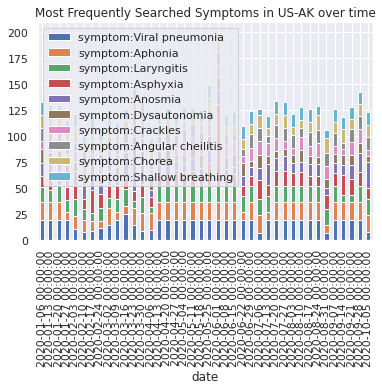

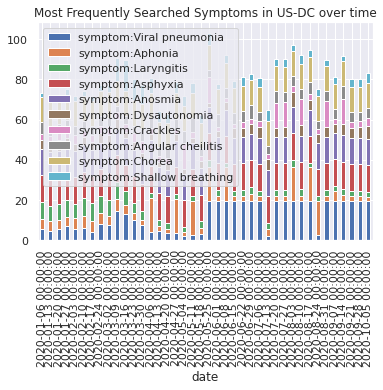

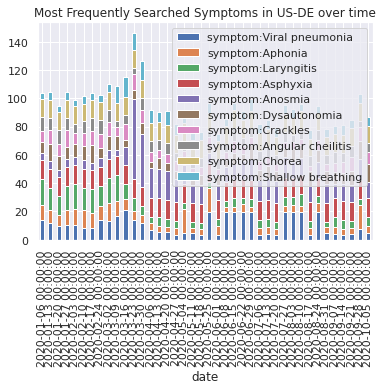

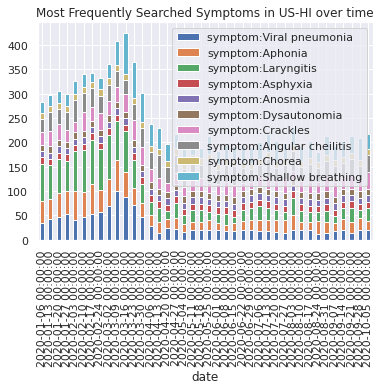

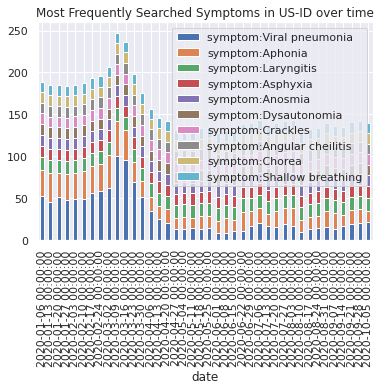

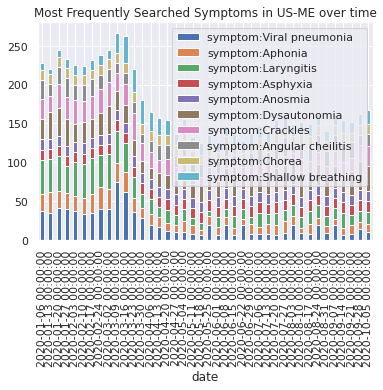

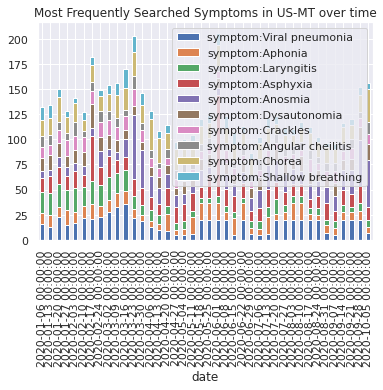

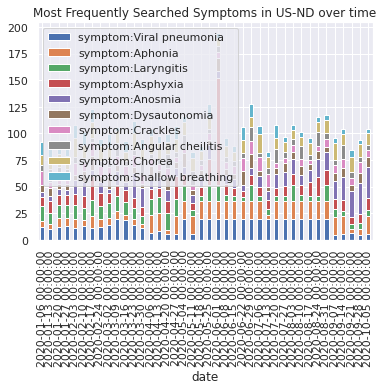

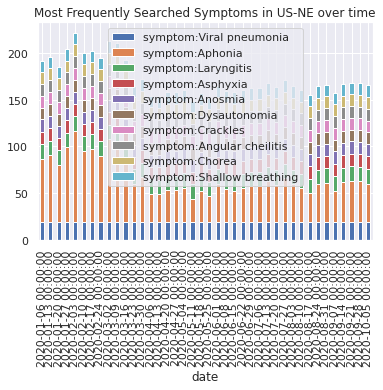

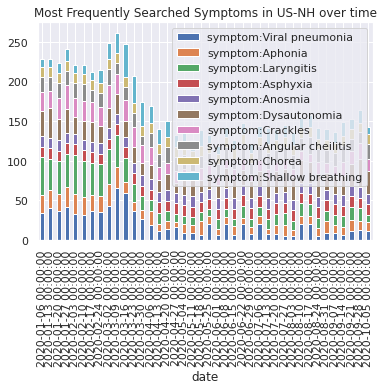

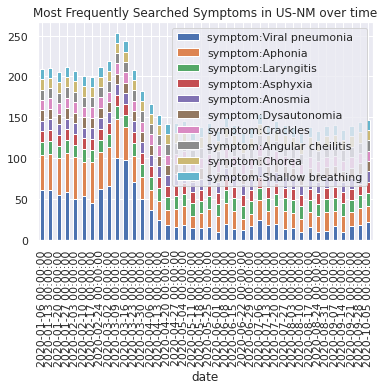

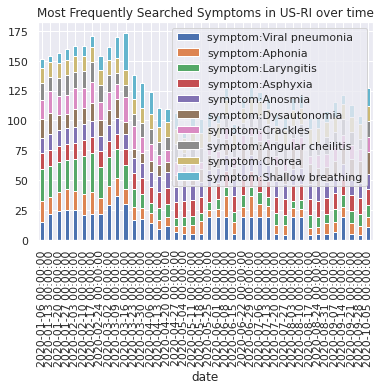

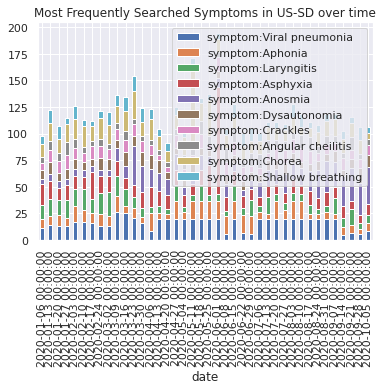

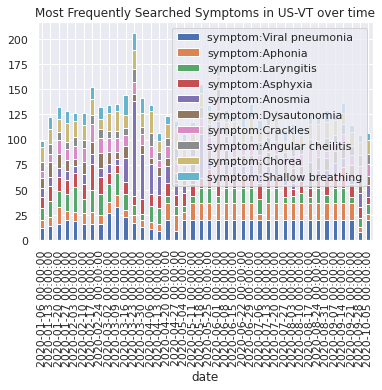

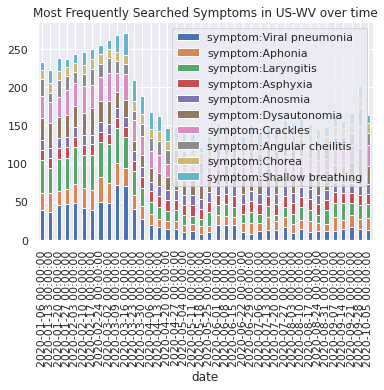

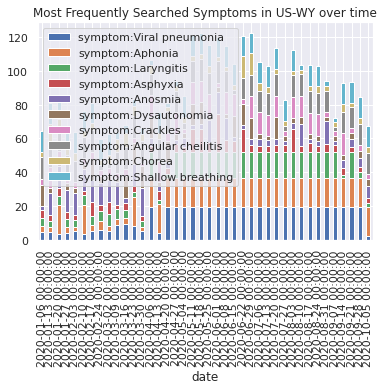

In [ ]:
top_symptoms = df_search.filter(like= 'symptom:').sum(axis = 0).sort_values(ascending = False).head(10).index.to_list()
top_symptoms.append('open_covid_region_code')
top_symptoms.append('date')


for region, group in df_search[top_symptoms].groupby(['open_covid_region_code']):
  group.plot(x = 'date', kind = 'bar', stacked  = True, title = 'Most Frequently Searched Symptoms in {} over time'. format (region))
  plt.show()


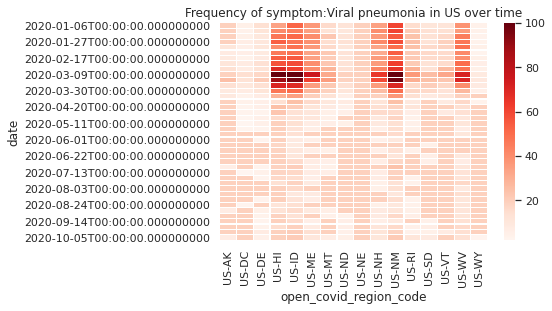

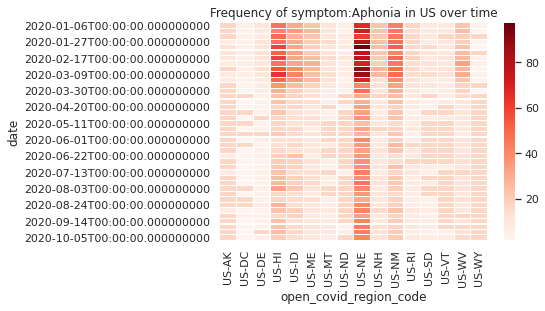

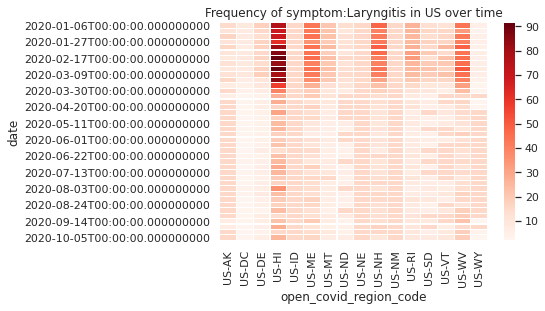

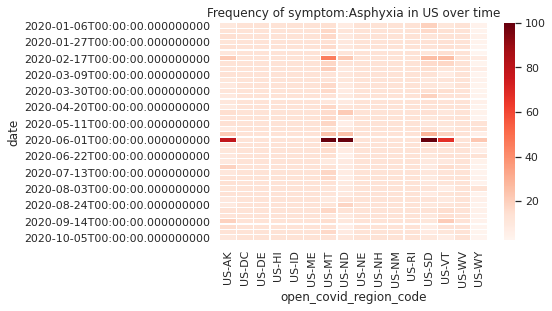

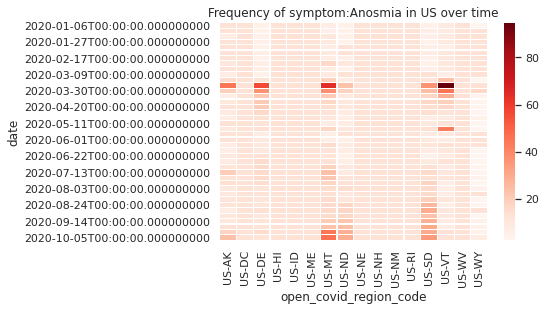

In [ ]:
top_symptoms = df_search.filter(like= 'symptom:').sum(axis = 0).sort_values(ascending = False).head(5).index.to_list()
for symptom in top_symptoms:
  data = df_search.pivot("date","open_covid_region_code", symptom)
  ax = sns.heatmap(data,linewidths=0.1, cmap="Reds")
  ax.set_title('Frequency of '+symptom+ ' in US over time')
  plt.show()
 





**Visualizing the search trends dataset in a lower dimensional space. Using Principal Component Analysis (PCA) to reduce the data dimensionality.**


> To perform PCA, we do these steps in order:


1.   We first separate our merged data into data and label components.
2.   Then we standardize our data
3.   Use sklearn PCA module to project our data to 2D principal components.












Original Data Space: (513, 82)
PCA projected Data Space: (513, 34)


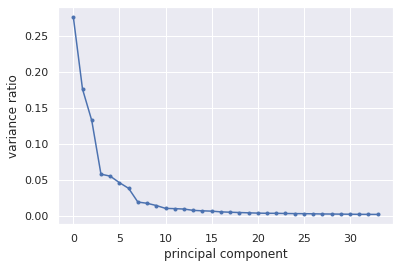

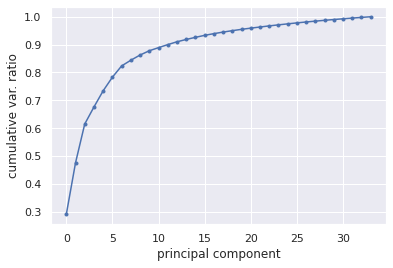

In [ ]:
symptoms_df = df_merged.filter(like= 'symptom:')

# PCA decomposition

# instances and features, expecting this variable name to change or removed
X = symptoms_df

# standardizing the dataset
X_rescaled = StandardScaler().fit_transform(X)

# define PCA
pca = PCA(0.95)   # using 95% of data variance

# fit and transform model with dataset
data_transf = pca.fit_transform(X)

print("Original Data Space:", X.shape)
print("PCA projected Data Space:", data_transf.shape)

plt.figure()
plt.plot((pca.explained_variance_ratio_),'.-')
plt.xlabel('principal component')
plt.ylabel('variance ratio')
plt.show()

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_) / np.sum(pca.explained_variance_ratio_),'.-')
plt.xlabel('principal component')
plt.ylabel('cumulative var. ratio')
plt.show()

(3, 82)


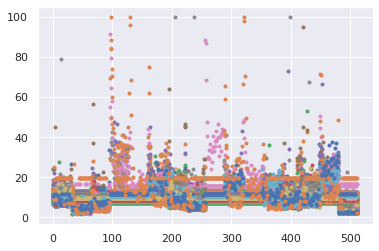

(3, 34)


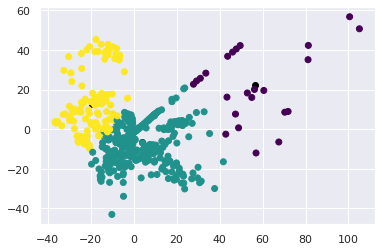

In [ ]:
# K-means Clustering, for now

# Hyper parameter: n clusters
n_clusters = 3

X = df_merged.filter(like= 'symptom:')

# clustering without PCF
kmeans = KMeans(n_clusters, random_state=0).fit(X)
print(kmeans.cluster_centers_.shape)
plt.figure()
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],  c='black')
plt.plot(X,'.')
plt.show()

# clustering with PCF
X_transf = data_transf
kmeans_transf = KMeans(n_clusters, random_state=0).fit(X_transf)
y_kmeans = kmeans_transf.predict(X_transf)
print(kmeans_transf.cluster_centers_.shape)
plt.figure()
centers  = kmeans_transf.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black')
plt.scatter(X_transf[:,0],X_transf[:,1], c=y_kmeans, cmap = 'viridis')
plt.show()

# Task 3 : Supervised Learning - KNNs and Decision Trees

**Subtasks**


1.   Splitting the data into train and validation sets based on regions and based on time.
2.  Compare the regression performance of KNNs and decision trees for each of the train-validation split strategies
3. Explore other prediction strategies.






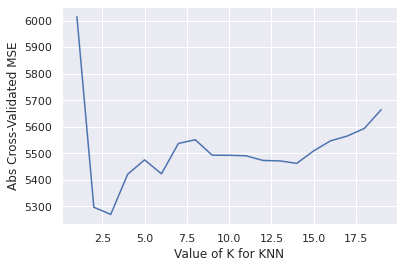

In [ ]:
# do KNNReg and 5 fold cross validation
k_range = range(1, 20)
symptoms_merged = df_merged.filter(like = "symptom:") 
X= pca.fit_transform(symptoms_merged)
y = df_merged["hospitalized_new"]

k_cost = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    cost = abs(cross_val_score(knn, X, y, cv=5, scoring='neg_mean_squared_error'))
    k_cost.append(cost.mean())

for i in range(len(k_range)):
  print(f"k: {k_range[i]}, k_cost: {k_cost[i]}, k")

plt.plot(k_range, k_cost)
plt.xlabel('Value of K for KNN')
plt.ylabel('Abs Cross-Validated MSE')
plt.show()

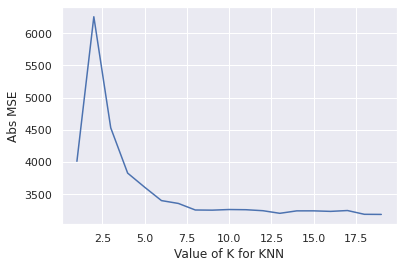

In [ ]:
# do KNNReg and 5 fold cross validation
SplitDate = "2020-08-10"

k_range = range(1, 20)
X = data_transf
y = df_merged

# splitting wrt Splitdate
y_train = df_merged[df_merged.date_y <= SplitDate]["hospitalized_new"]
y_test = df_merged[df_merged.date_y > SplitDate]["hospitalized_new"]
X_train = data_transf[:len(y_train),:]
X_test = data_transf[len(y_train):,:]

k_cost = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    cost = abs(mean_squared_error(y_test, y_pred))
    k_cost.append(cost)

plt.plot(k_range, k_cost)
plt.xlabel('Value of K for KNN')
plt.ylabel('Abs MSE')
plt.show()

[[ 0  0  0 ...  0  0  0]
 [ 0 29  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

       -36.0       0.00      0.00      0.00         0
         0.0       0.69      0.63      0.66        46
         1.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         2
         9.0       0.00      0.00      0.00         2
        10.0       0.00      0.00      0.00         0
        11.0       0.00      0.00      0.00         0
        14.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[6661.799445851048, 6710.0095161356485, 6821.0854609947655, 6899.973547289352, 7757.481734678802, 8072.314766600347, 8161.881335030051, 8667.526554227437, 9067.533788306502, 9122.426166956864, 8564.096682051128, 8821.071792259409, 8626.637830207133, 8723.357248098724, 8580.350815282824, 8429.798354170867, 8567.257789199823, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923, 8575.33826384923]


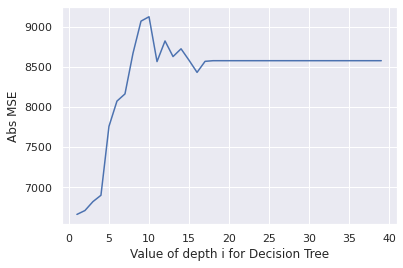

In [ ]:
 # DECISION TREE USING REGION BASED 5-FOLD

df_dtree =df_merged.filter(like= 'symptom:')
pca_dtree = PCA(0.95) #value found from PCA
X_dtree = pca_dtree.fit_transform(df_dtree)
y_dtree=df_merged['hospitalized_new']
scaler=StandardScaler()
X_dtree=scaler.fit_transform(X_dtree)

X_train, X_test, y_train, y_test = train_test_split(X_dtree, y_dtree, test_size=0.20,)
# fit the regressor with X and Y data 
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


depth = []
i_range= range(1,40)
for i in i_range:
    tree = DecisionTreeRegressor(random_state = 0, max_depth=i) 
    # Perform 5-fold cross validation 
    scores = abs(cross_val_score(estimator=tree, X=X_dtree, y=y_dtree, cv=5,scoring='neg_mean_squared_error'))
    depth.append(scores.mean())

print(depth)
plt.plot(i_range, depth)
plt.xlabel('Value of depth i for Decision Tree')
plt.ylabel('Abs MSE')
plt.show()







[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

       -45.0       0.00      0.00      0.00         0
       -36.0       0.00      0.00      0.00         0
        -1.0       0.00      0.00      0.00         0
         0.0       0.37      0.53      0.43        40
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00         4
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         1
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1
        14.0   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


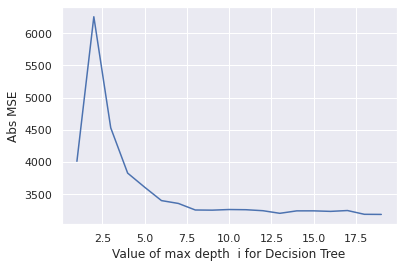

In [ ]:
# DECISION TREE USING TIME BASED 5-FOLD
SplitDate = "2020-08-10"


i_range = range(1, 40)


# splitting wrt Splitdate
y_train = df_merged[df_merged.date_y <= SplitDate]["hospitalized_new"]
y_test = df_merged[df_merged.date_y > SplitDate]["hospitalized_new"]
X_train = data_transf[:len(y_train),:]
X_test = data_transf[len(y_train):,:]

scaler=StandardScaler()

# fit the regressor with X and Y data 
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

i_cost = []
for i in i_range:
    tree = DecisionTreeRegressor(random_state=0, max_depth=i)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    cost = abs(mean_squared_error(y_test, y_pred))
    i_cost.append(cost)

plt.plot(k_range, k_cost)
plt.xlabel('Value of max depth  i for Decision Tree')
plt.ylabel('Abs MSE')
plt.show()